# Variational Quantum Classifier using Fire Opal
**Test VQC using Fire Opal's `estimate_expectation` function**

Quantum Machine Learning (QML) techniques are widely used and researched today. They are motivated by advances achieved in different knowledge fields.  However, the noise and decoherence in real quantum devices limit their implementation by inducing errors in the calculations.  Fire Opal provides an automated suite of error suppression methods enabling Quantum Machine Learning on today’s quantum computers.

This tutorial provides an example of implementing a Variational Quantum Classifier (VQC) covering the following information:

* Implementing a VQC on a synthetic dataset, training it using IBM Qiskit Simulator
* Testing the model using IBM Qiskit Simulator
* Testing the model using real quantum devices
* Testing the model using real quantum devices using Fire Opal error suppression

Ultimately, we demonstrate how Fire Opal enhances the results obtained using real quantum devices.

## 1. Introduction

A Variational Quantum Classifier (VQC) is a quantum machine learning model based on parameterized quantum circuits to perform classification tasks. The VQC presented in Figure 1, works by encoding classical input data into quantum states through a data encoding circuit, followed by a variational circuit with a series of quantum gates whose parameters are optimized during training. These classifiers are part of the broader family of hybrid quantum-classical algorithms, where a classical optimizer is used to update the quantum circuit’s parameters based on a cost function.

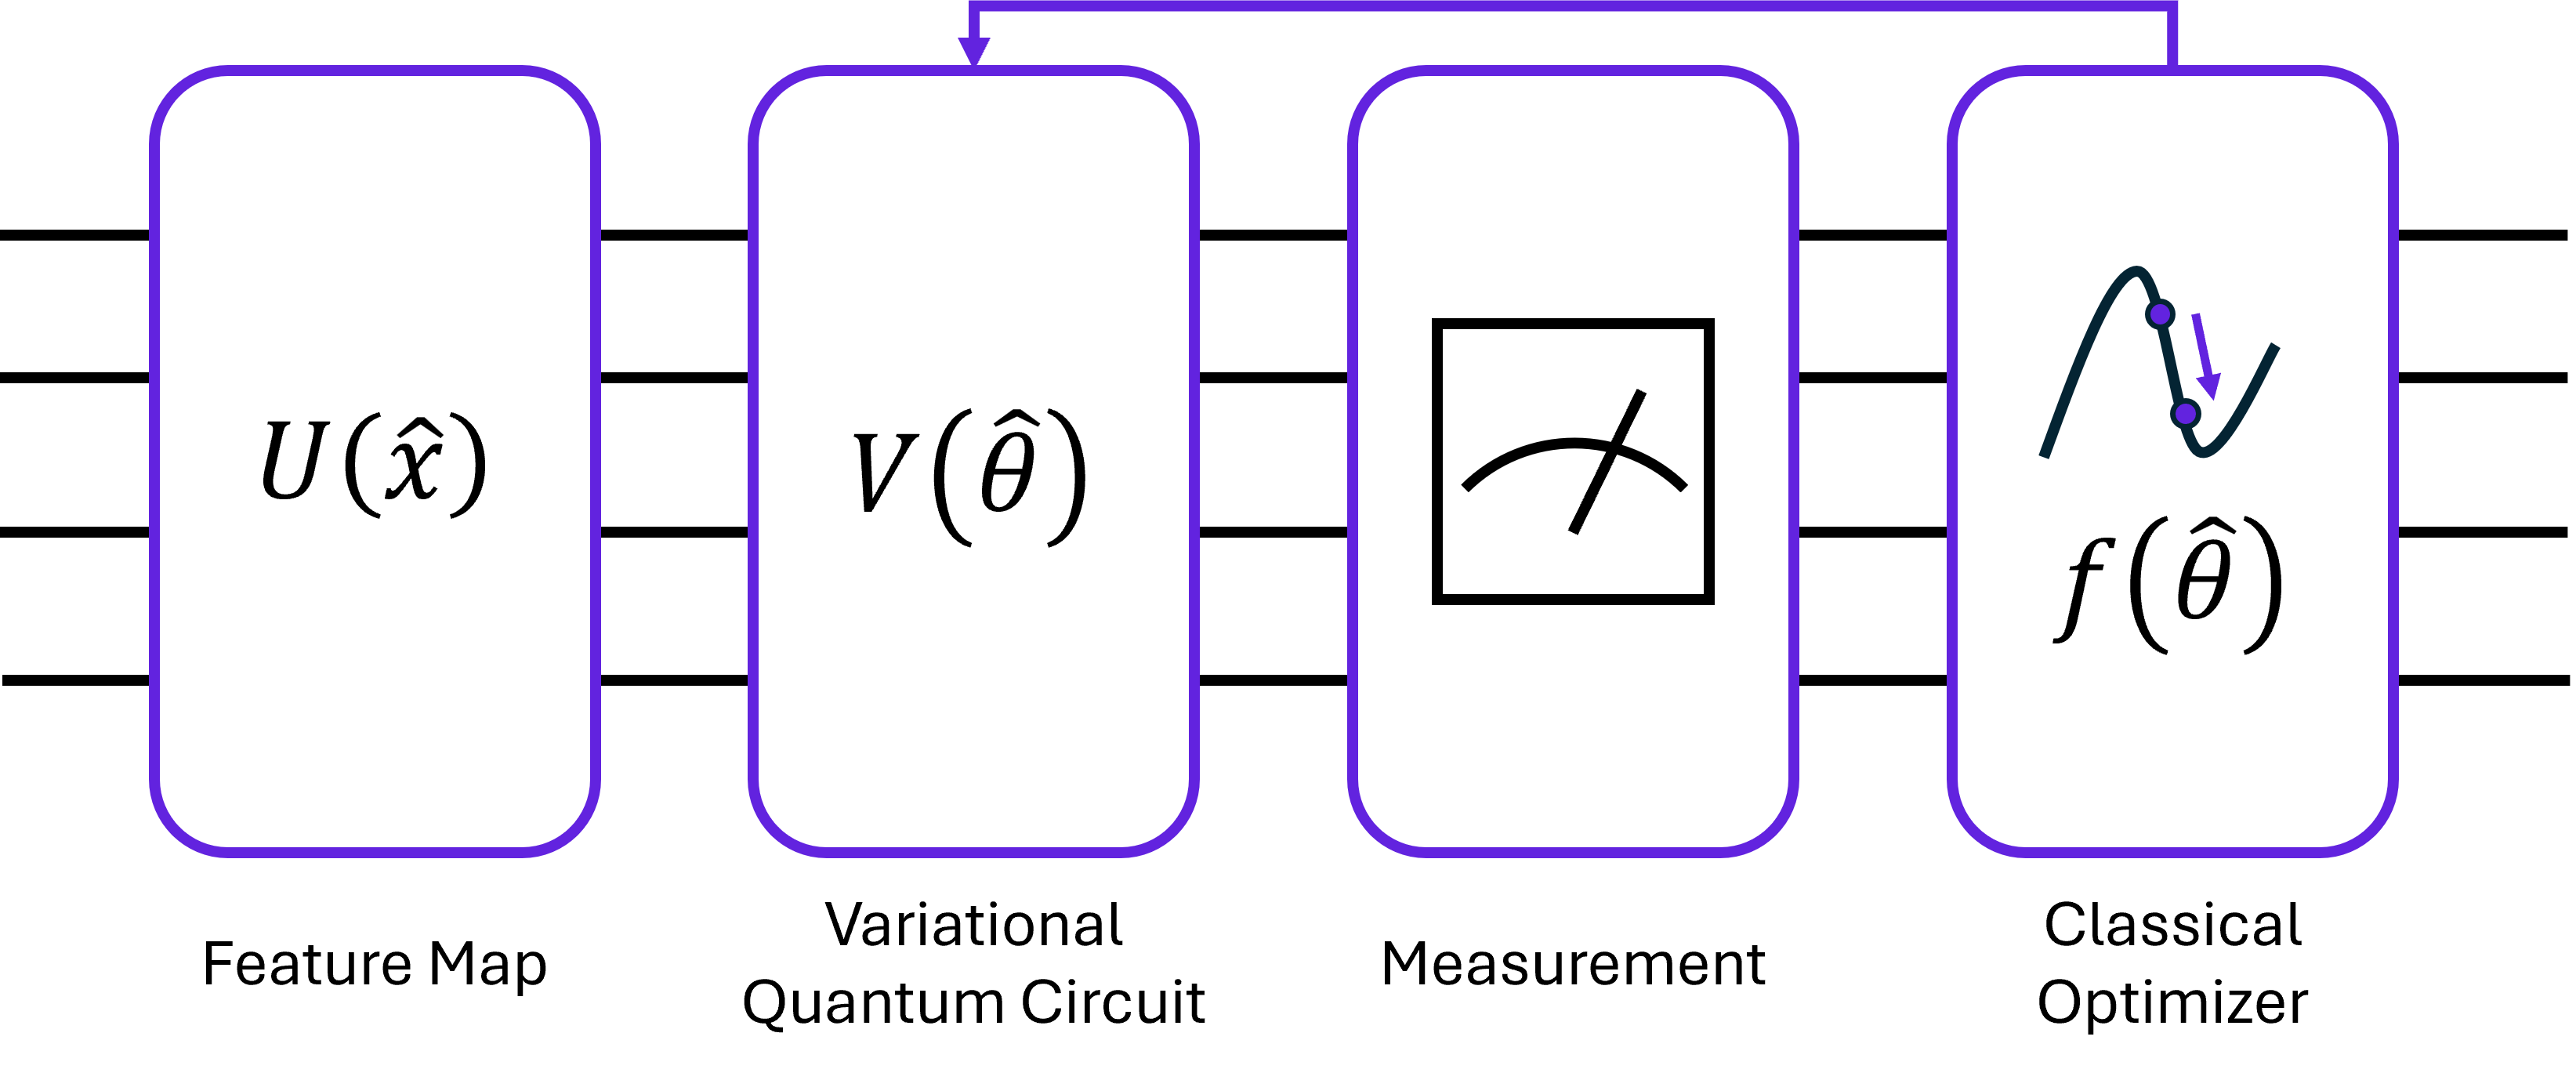
**Figure 1:** Variational Quantum Classifier circuit scheme.

## 2. Imports and initialization
You can find detailed guidelines for [setting up your development environment](https://docs.q-ctrl.com/fire-opal/discover/start-using/how-to-set-up-and-install-fire-opal). To install the required packages, use the following command:

In [ ]:
%pip install fire-opal numpy matplotlib qiskit qiskit-machine-learning qiskit-ibm-runtime scikit-learn qctrl-visualizer

After setting up the environment, you need to load the libraries. Fire Opal may include informative Runtime warnings during execution.

In [1]:
# Packages for synthetic data generation and pre-processing.
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.datasets import make_blobs

# Qiskit packages
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit_machine_learning.optimizers import SPSA
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Fire Opal packages
import fireopal as fo
import qctrlvisualizer as qv
from qiskit import qasm3

# Packages for data visualization
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

plt.style.use(qv.get_qctrl_style())

### 2.1 Setting up credentials for Fire Opal

To use Fire Opal within your local development environment or the Braket console you should [authenticate using an API key](https://docs.q-ctrl.com/fire-opal/discover/start-using/how-to-set-up-and-install-fire-opal).


In [ ]:
api_key = "YOUR_QCTRL_API_KEY"
fo.authenticate_qctrl_account(api_key=api_key)

Q-CTRL authentication successful!


When using IBM Quantum Platform you will need to set up your IBM account credentials in order to test your solution on real hardware using Fire Opal. If you are using Amazon Braket you don't need to run this cell.

In [5]:
# Set credentials.
# These are the properties for the publicly available provider for IBM backends.
# If you have access to a private provider and wish to use it, replace these values.
hub = "ibm-q"
group = "open"
project = "main"
token = "YOUR_IBM_TOKEN"

credentials = fo.credentials.make_credentials_for_ibmq(
    token=token, hub=hub, group=group, project=project
)

## 3. Import the dataset

You can generate synthetic datasets using `make_blobs` from scikit-learn, which is useful for clustering and classification experiments. In this application, we use `make_blobs` to simulate a dataset with $120$ samples distributed evenly across $4$ distinct clusters with clear class separation and high-dimensional feature space. Each sample is described by $46$ continuous numerical features, with a small within-cluster standard deviation.

In [6]:
X, y = make_blobs(
    n_samples=120, centers=4, n_features=46, cluster_std=0.05, random_state=42
)

Then randomly divide the data into two subsets, one for training and one for testing. The testing subset will contain 20% of the generated records and will not be part of the training process. 

In [7]:
train_data, test_data, train_labels, test_labels = train_test_split(
    X, y, test_size=0.2, random_state=24
)

## 4. Circuit Preparation

One of the key components of the VQC method is the feature map definition, which maps data nonlinearly into the Hilbert space of a quantum system, creating the vectors $|\phi(\tilde{x})\rangle\langle\phi(\tilde{x})|$. The correct data mapping could lead to better classification performance. In this example, you will implement a Multiscale Entanglement Renormalization Ansatz tensor network. This hierarchical quantum circuit architecture encodes classical data into highly entangled quantum states across multiple scales, capturing both local and global correlations in the input data.

The variational circuit selected is [`RealAmplitudes`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.RealAmplitudes) that alternates layers of $Y$ gates with $CNOT$. You will use three repetitions leading to $24$ tunable parameters.


In [2]:
def feature_encoding():
    x = ParameterVector("x", 60)
    qc = QuantumCircuit(20)
    p = 0
    for q in range(0, 20, 2):
        qc.ryy(x[p], q, q + 1)
        p += 1
    for q in range(0, 20, 2):
        qc.ry(x[p], q)
        p += 1
        qc.cx(q, q + 1)
    for q in range(1, 19, 2):
        qc.ryy(x[p], q, q + 1)
        p += 1
    for q in range(1, 19, 2):
        qc.ry(x[p], q)
        p += 1
        qc.cx(q, q + 1)
    for q in range(2, 18, 4):
        qc.ryy(x[p], q, q + 2)
        p += 1
    for q in range(2, 18, 4):
        qc.ry(x[p], q)
        p += 1
        qc.cx(q, q + 2)
    return qc

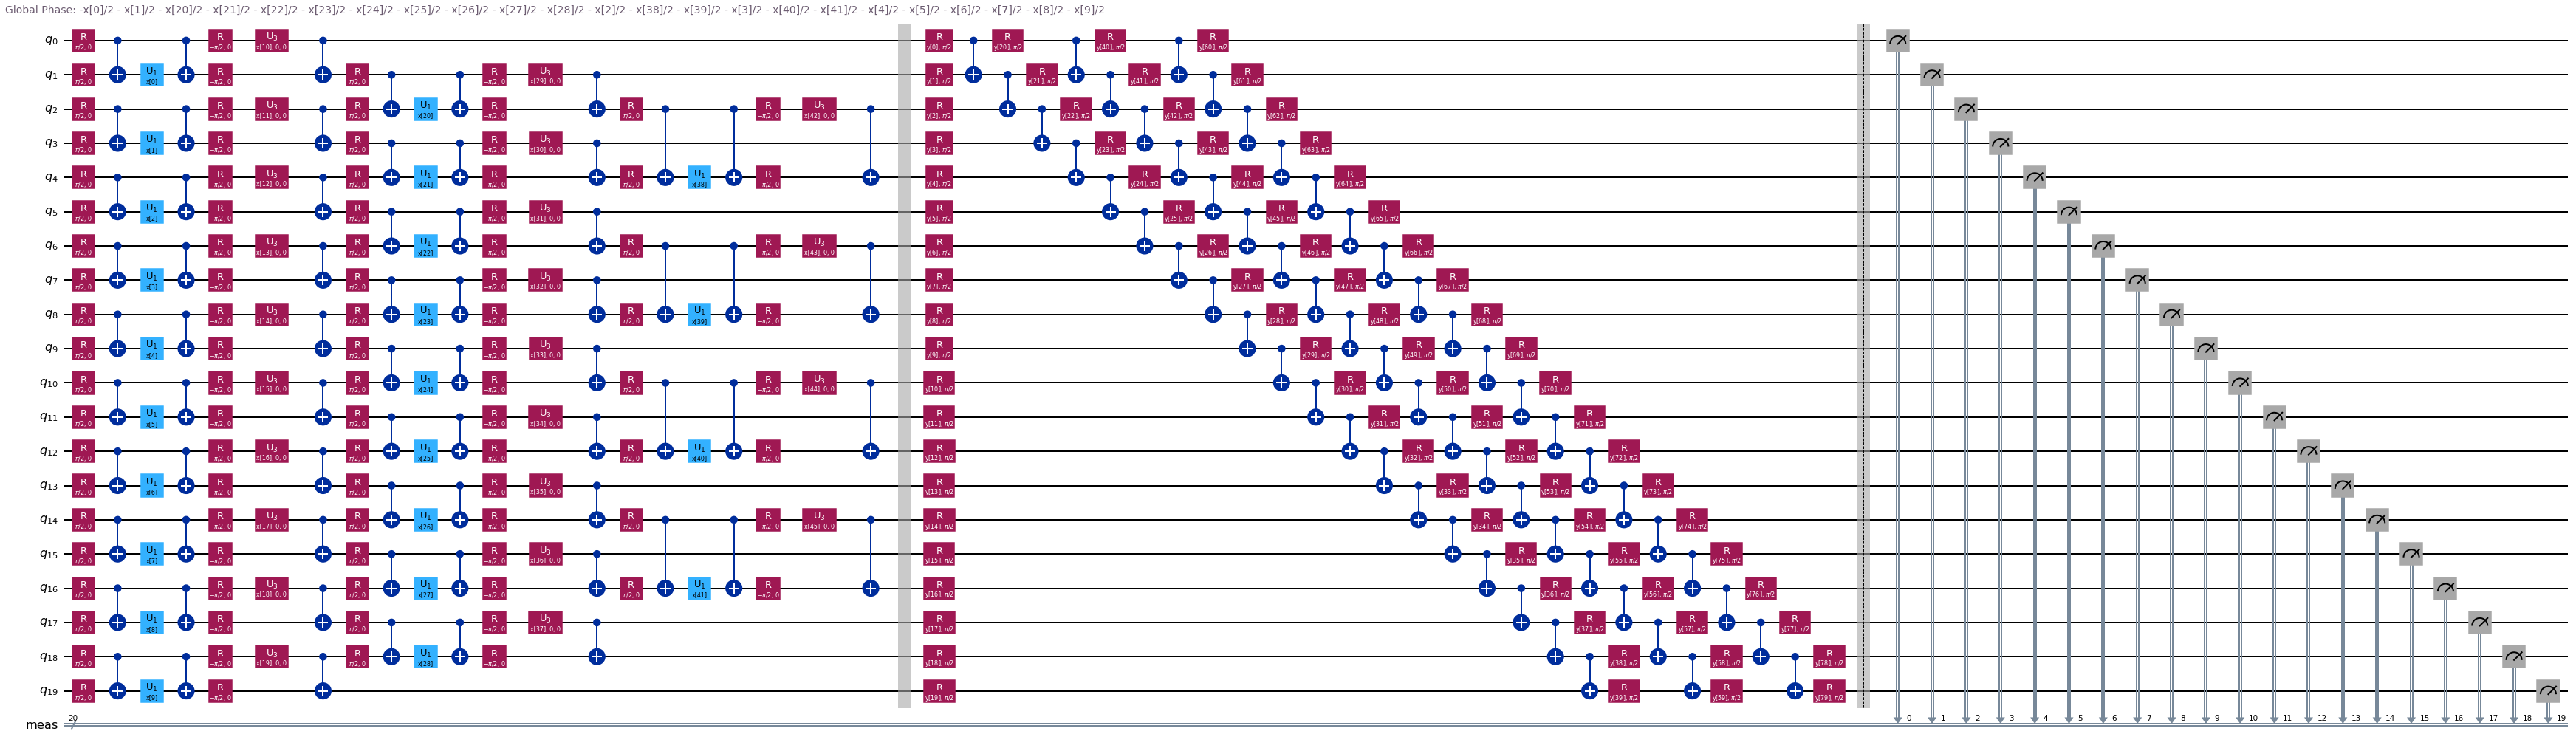

In [3]:
feature_map = feature_encoding()
feature_map.barrier()
var_form = RealAmplitudes(
    num_qubits=20, reps=3, entanglement="linear", parameter_prefix="y"
)
circuit = feature_map.compose(var_form).decompose()
circuit.measure_all()
circuit.decompose().draw(output="mpl", fold=-1, style="iqp")

## 5. VQC Training

You have to create the functions needed to tune the variational parameters from our quantum circuit. First, create a function to assign the data to the parameters of the feature map. These parameters will be updated in the variational circuit with the optimization algorithm.

In [10]:
# Assign parameters for training and qiskit testing
def circuit_instance(data, variational):
    parameters = {}
    for i, p in enumerate(feature_map.parameters):
        parameters[p] = data[i]
    for i, p in enumerate(var_form.ordered_parameters):
        parameters[p] = variational[i]
    return circuit.assign_parameters(parameters)


# Assign parameters for Fire-Opal testing
def parameters_dictionary(data, variational):
    parameters = {}
    for param, val in zip(feature_map.parameters, data):
        parameters[param.name] = val
    for param, val in zip(var_form.ordered_parameters, variational):
        parameters[param.name] = val
    return parameters

For classification, three observables will be utilized to distinguish between classes based on measurements of entangled qubit pairs across the circuit, each observable will be associated with a class. Rather than using overlapping or adjacent qubit pairs, these observables are designed to span different regions of the 20-qubit system. This ensures that the measurements provide complementary information.

In [11]:
observables = [
    ("ZZZZIIIIIIIIIIIIIIII", 1),
    ("IIIIIZZZZIIIIIIIIIII", 1),
    ("IIIIIIIIIIIZZZIIIIII", 1),
    ("IIIIIIIIIIIIIIIIIIZZ", 1),
]

In [12]:
def labels_probability(results):
    results = np.array(results)
    results_min = results.min()
    results_max = results.max()
    probabilities = (results - results_min) / (results_max - results_min)
    return probabilities

The function ```classification_probability_simulation``` builds a quantum circuit for each data point using the variational parameters. It then runs these circuits using the IBM Qiskit Simulator and calculates the classification probabilities based on the circuit results, using the ```multiclass_cross_entropy``` function to provide a measure of prediction accuracy.

In [13]:
backend = AerSimulator()
opp = []
for pauli_string, coeff in observables:
    op = SparsePauliOp.from_list([(pauli_string, coeff)])
    opp.append(op)


def classification_probability_simulation(data, variational):
    lst = []
    for d in data:
        circ = circuit_instance(d, variational)
        pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
        isa_circuit = pm.run(circ)
        isa_observable = [None] * len(opp)
        for i, op in enumerate(opp):
            isa_observable[i] = op.apply_layout(isa_circuit.layout)
        estimator = Estimator(backend, options={"default_shots": int(4096)})
        job = estimator.run([(isa_circuit, obs) for obs in isa_observable])
        lst.extend([job.result()[i].data.evs.item() for i in range(len(observables))])
    s = len(observables)
    results = [lst[i : i + s] for i in range(0, len(lst), s)]
    classification = [labels_probability(results[i]) for i, _ in enumerate(data)]
    return classification

In [14]:
def multiclass_cross_entropy(y_pred, y_true, epsilon=1e-15):
    oh = np.zeros(len(observables), dtype=int)
    oh[y_true] = 1
    y_true = oh
    y_pred = np.clip(y_pred, epsilon, 1.0 - epsilon)
    loss = -np.sum(y_true * np.log(y_pred))
    return np.mean(loss)

The ```cost_function``` evaluates the overall performance of the quantum circuit given variational parameters on the dataset by finding the average of the multiclass cross-entropy loss across all data points, which is then used by the ```objective_function``` to minimize the cost.

In [15]:
def cost_function(data, labels, variational):
    classifications = classification_probability_simulation(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += multiclass_cross_entropy(classification, labels[i])
    cost /= len(data)
    return cost

In [16]:
def objective_function(variational):
    return cost_function(train_data, train_labels, variational)

Now you are ready to run the program and obtain the variational parameters from the circuit, using the SPSA algorithm from SciPy to minimize the function.

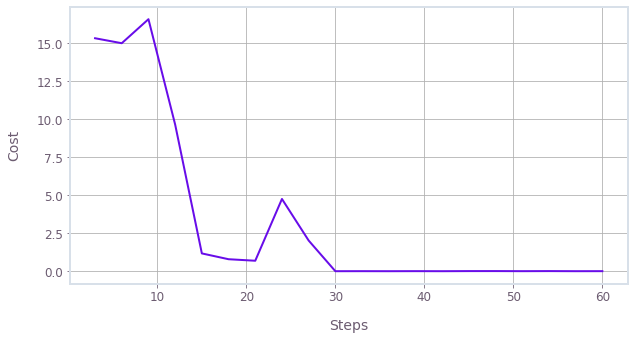

In [ ]:
class OptimizerLog:
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
        self.stepsizes = []
        self.accepts = []

    def update(
        self, evaluation, parameter=None, cost=None, _stepsize=None, _accept=None
    ):
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)
        self.stepsizes.append(_stepsize)
        self.accepts.append(_accept)


log = OptimizerLog()
optimizer = SPSA(maxiter=20, callback=log.update)
initial_point = np.zeros((var_form.num_parameters))

result = optimizer.minimize(objective_function, initial_point)
opt_var = result.x
opt_value = result.fun
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.grid(True)
plt.rc("axes", linewidth=2)
ax = plt.gca()
ax.spines["top"].set_linewidth(2)
ax.spines["right"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
plt.show()

## 6. Model Evaluation

Now that the model is trained, you will evaluate its performance using the test subset you isolated at the beginning. The evaluation is achieved through three experiments: 

*	**Simulator Test:** You will test the model using the simulator, which will provide information about the model performance in a noiseless environment and serve as the baseline to evaluate the performance of the executions using real devices.
*	**Default Backend Test:** We will test the model executing the inference circuits on a real device to assess the noise and decoherence effect in the model.
*	**Fire Opal Test:** We will test the model using Fire Opal tools when executing the inference circuits on a real device to evaluate the noise suppression effect in the model performance.



### 6.1 Simulator Test

In [ ]:
def create_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100
    colors = [(1, 1, 1), (98 / 255, 35 / 255, 223 / 255)]
    n_bins = 100
    cmap_name = "custom_blue"
    custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    fig, ax = plt.subplots()
    cax = ax.matshow(cm_normalized, cmap=custom_cmap)
    fig.colorbar(cax)
    for i in range(cm_normalized.shape[0]):
        for j in range(cm_normalized.shape[1]):
            color = "white" if i == j else "black"
            ax.text(
                j,
                i,
                f"{cm_normalized[i, j]:.1f}%",
                va="center",
                ha="center",
                color=color,
            )
    diagonal_color = (98 / 255, 35 / 255, 223 / 255)
    for i in range(cm_normalized.shape[0]):
        ax.add_patch(
            plt.Rectangle(
                (i - 0.5, i - 0.5), 1, 1, fill=True, color=diagonal_color, alpha=0.3
            )
        )
    background_color = (1, 1, 1)
    fig.patch.set_facecolor(background_color)
    ax.set_facecolor(background_color)
    plt.title(title)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

Simulated Test Accuracy: 91.67%


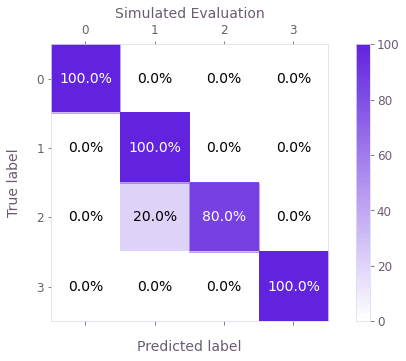

In [ ]:
def test_classifier(data, labels, variational):
    probability = classification_probability_simulation(data, variational)
    predictions = [np.argmax(p) for p in probability]
    accuracy = 0
    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    print(f"Simulated Test Accuracy: {accuracy * 100:.2f}%")
    create_confusion_matrix(labels, predictions, "Simulated Evaluation")
    return accuracy, predictions


accuracy_sim, predictions_sim = test_classifier(test_data, test_labels, opt_var)

### 6.2 Default Backend Test
You need to change the `Estimator` function to define the hardware backend you will use, rewriting the circuit to match the topology from this backend in a process known as [transpilation](https://docs.quantum.ibm.com/api/qiskit/transpiler).

In [ ]:
# Initialize the runtime service and get a backend
service = QiskitRuntimeService()
backend_name = "YOUR-DESIRED-BACKEND"
backend = service.backend(backend_name)

In [20]:
def classification_probability_qiskit(data, variational):
    lst = []
    for d in data:
        circ = circuit_instance(d, variational)
        pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
        isa_circuit = pm.run(circ)
        isa_observable = [None] * len(opp)
        for i, op in enumerate(opp):
            isa_observable[i] = op.apply_layout(isa_circuit.layout)
        estimator = Estimator(backend, options={"default_shots": int(4096)})
        job = estimator.run([(isa_circuit, obs) for obs in isa_observable])
        lst.extend([job.result()[i].data.evs.item() for i in range(len(observables))])
    s = len(observables)
    results = [lst[i : i + s] for i in range(0, len(lst), s)]
    classification = [labels_probability(results[i]) for i, _ in enumerate(data)]
    return classification

Qiskit Test Accuracy: 41.67%


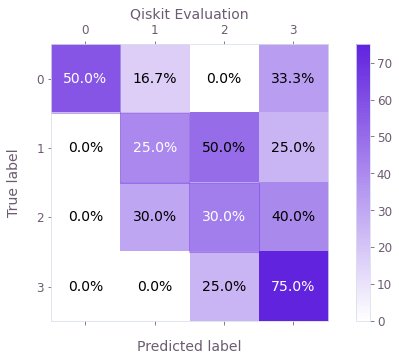

In [ ]:
def test_classifier(data, labels, variational):
    probability = classification_probability_qiskit(data, variational)
    predictions = [np.argmax(p) for p in probability]
    accuracy = 0
    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    print(f"Qiskit Test Accuracy: {accuracy * 100:.2f}%")
    create_confusion_matrix(labels, predictions, "Qiskit Evaluation")
    return accuracy, predictions


accuracy_def, predictions_def = test_classifier(test_data, test_labels, opt_var)

### 6.3 Fire Opal Test

In this test, you also need to modify some of the functions to execute circuits through Fire Opal, you will use the ```iterate_expectation``` function that allows for [running circuits on quantum hardware](https://docs.q-ctrl.com/fire-opal/execute/submit-jobs/how-to-run-jobs-on-quantum-hardware) obtaining the expectation values from a given set of observables. Some information about the selected backends may appear as RuntimeWarnings, you could follow these instructions to obtain better performance. 

In [25]:
def classification_probability_FO(data, variational):
    job_status = None
    parameters_dict = [parameters_dictionary(d, variational) for d in data]
    job = fo.estimate_expectation(
        circuits=[qasm3.dumps(circuit)],
        shot_count=1024,
        credentials=credentials,
        backend_name=backend_name,
        parameters=parameters_dict,
        observables=observables,
    )
    lst = job.result()["expectation_values"]
    s = len(observables)
    results = [lst[i : i + s] for i in range(0, len(lst), s)]
    classification = [
        labels_probability(results[i]) for i, _ in enumerate(parameters_dict)
    ]
    return classification

Fire-Opal Test Accuracy: 87.50%


c:\ProgramData\Anaconda3\envs\qiskit\Lib\site-packages\qctrlworkflowclient\functions.py:191: RuntimeWarning: The measurement error is much higher than the median right now. This will negatively impact Q-CTRL's performance. For better results, try running on a different device. Visit https://quantum-computing.ibm.com/services/resources?tab=systems&system=ibm_sherbrooke for information on device error rates.
  warn(warning, RuntimeWarning)
c:\ProgramData\Anaconda3\envs\qiskit\Lib\site-packages\qctrlworkflowclient\functions.py:191: RuntimeWarning: The X gate error is much higher than the median right now. This will negatively impact Q-CTRL's performance. For better results, try running on a different device. Visit https://quantum-computing.ibm.com/services/resources?tab=systems&system=ibm_sherbrooke for information on device error rates.
  warn(warning, RuntimeWarning)


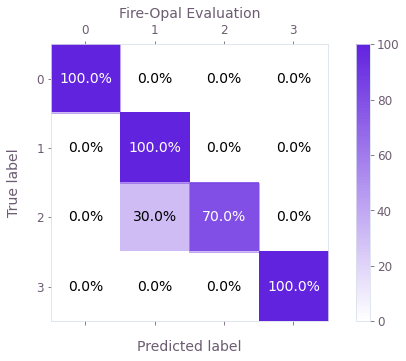

In [ ]:
def test_classifier(data, labels, variational):
    probability = classification_probability_FO(data, variational)
    predictions = [np.argmax(p) for p in probability]
    accuracy = 0
    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    print(f"Fire-Opal Test Accuracy: {accuracy * 100:.2f}%")
    create_confusion_matrix(labels, predictions, "Fire-Opal Evaluation")
    return accuracy, predictions


accuracy_FO, predictions_FO = test_classifier(test_data, test_labels, opt_var)

## 7. Comparison

You can compare the model perfomance for the results obtained with the Simulator, with Fire Opal and by default

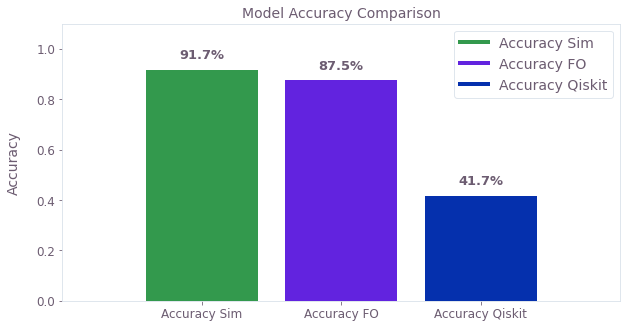

In [27]:
labels = ["Accuracy Sim", "Accuracy FO", "Accuracy Qiskit"]
accuracies = [accuracy_sim, accuracy_FO, accuracy_def]
colors = [
    (0.2, 0.6, 0.3),
    (98 / 255, 35 / 255, 223 / 255),
    (5 / 255, 48 / 255, 173 / 255),
]
fig, ax = plt.subplots()
bar_width = 0.4
bar_spacing = 0.5
bar_positions = np.arange(len(labels)) * bar_spacing
bars = ax.bar(bar_positions, accuracies, color=colors, width=bar_width)
ax.set_ylabel("Accuracy")
ax.set_title("Model Accuracy Comparison")
ax.set_ylim(0, 1.1)
ax.set_xticks(bar_positions)
ax.set_xticklabels(labels)
for bar in bars:
    height = bar.get_height()
    ax.annotate(
        f"{height*100:.1f}%",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 8),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=13,
        fontweight="bold",
    )
ax.set_xlim(-0.5, bar_positions[-1] + 0.5)
custom_lines = [plt.Line2D([0], [0], color=colors[i], lw=4) for i in range(len(labels))]
ax.legend(custom_lines, labels)
plt.show()

Comparing the accuracy obtained with or without Fire Opal normalized by the noiseless simulation accuracy becomes a way to quantify the execution quality rather than just the model quality. This is achieved by calculating:

$$\text{Normalized Accuracy} = \frac{\text{Execution Accuracy}}{\text{Simulator Accuracy}}$$

where:

* **Execution Accuracy:** is the model performance under noisy conditions from a real quantum hardware
* **Simulator Accuracy:** is the model performance on simulated noiseless conditions

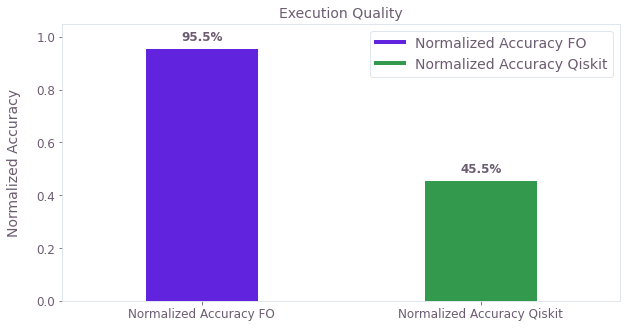

In [29]:
labels = ["Normalized Accuracy FO", "Normalized Accuracy Qiskit"]
accuracies = [accuracy_FO / accuracy_sim, accuracy_def / accuracy_sim]
colors = [
    (98 / 255, 35 / 255, 223 / 255),
    (0.2, 0.6, 0.3),
    (5 / 255, 48 / 255, 173 / 255),
]
fig, ax = plt.subplots()
bar_width = 0.04  # Thinner bars
bar_spacing = 0.1  # Space between bars
bar_positions = np.arange(len(labels)) * bar_spacing
bars = ax.bar(bar_positions, accuracies, color=colors[: len(labels)], width=bar_width)
ax.set_ylabel("Normalized Accuracy")
ax.set_title("Execution Quality")
ax.set_ylim(0, 1)
ax.set_xticks(bar_positions)
ax.set_xticklabels(labels)
for bar in bars:
    height = bar.get_height()
    ax.annotate(
        f"{height*100:.1f}%",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold",
    )
ax.set_xlim(-bar_spacing * 0.5, bar_positions[-1] + bar_spacing * 0.5)
ax.set_ylim(0, 1.05)
custom_lines = [plt.Line2D([0], [0], color=colors[i], lw=4) for i in range(len(labels))]
ax.legend(custom_lines, labels)
plt.show()

Implementing a Variational Quantum Classifier (VQC) and evaluating this model on a simulator and a hardware backend with Fire Opal’s error suppression, shows the benefits of Fire Opal in the execution of Variational Circuits, bringing the results closer to the ideal results observed in simulations, making feasible the use of VQC models on today’s quantum computers. 

In [30]:
from fireopal import print_package_versions

print_package_versions()

| Package               | Version |
| --------------------- | ------- |
| Python                | 3.12.9  |
| matplotlib            | 3.10.1  |
| networkx              | 2.8.8   |
| numpy                 | 1.26.4  |
| qiskit                | 1.4.2   |
| qiskit-ibm-runtime    | 0.36.1  |
| sympy                 | 1.13.3  |
| fire-opal             | 8.4.1   |
| qctrl-visualizer      | 8.0.2   |
| qctrl-workflow-client | 5.5.0   |
